In [2038]:
import localized_narratives
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle as pkl
from scipy.spatial import ConvexHull
from matplotlib.path import Path

<h1>Step 0: Visualise Dataset</h1>

Open Images dataset only has single object segmentation masks. The researchers must have used a separate segmentation model to obtain the "gold standard segmentation masks" for images from the Open Images.

Faced difficulty installing the package named fiftyone for downloading images from Open Images due to lack of support for various dependencies such as scikit-learn for M1 Macs.

I chose ADE20k because they came with complete segmentations masks and also allowed me to register for a download link.

<h3>I) Get Localized Narratives (ADE20k)</h3>

In [2039]:
"""https://github.com/google/localized-narratives/blob/master/demo.py"""

# This folder is where you would like to download the annotation files to and
# where to read them from.
local_dir = os.getcwd()

# The DataLoader class allows us to download the data and read it from file.
data_loader = localized_narratives.DataLoader(local_dir)

# Downloads the annotation files (it first checks if they are not downloaded).
data_loader.download_annotations('ade20k_val')

# Iterates through all or a limited number of (e.g. 1 in this case) annotations
# for all files found in the local folder for a given dataset and split. E.g.
# for `open_images_train` it will read only one shard if only one file was
# downloaded manually.
loc_narr = next(data_loader.load_annotations('ade20k_val', 1))

print(f'\nLocalized Narrative sample:\n{loc_narr}')

print(f'\nVoice recording URL:\n {loc_narr.voice_recording_url}\n')

Already downloaded: ade20k_validation_localized_narratives.jsonl

Localized Narrative sample:
{
 dataset_id: ADE20k,
 image_id: ADE_val_00000175,
 annotator_id: 125,
 caption: In this image on the left side I can see a bed and a window....,
 timed_caption: [{'utterance': 'In', 'start_time': 0.0, 'end_time': 0.0}, ...],
 traces: [[{'x': 0.6408, 'y': 0.1371, 't': 0.013}, ...], ...],
 voice_recording: ade20k_validation/ade20k_validation_ADE_val_00000175_125.ogg
}

Voice recording URL:
 https://storage.googleapis.com/localized-narratives/voice-recordings/ade20k_validation/ade20k_validation_0000000000000175_125.ogg



<h3>II) Show Image from ADE20k</h3>

The .zip file itself was already 6.04GB. I tried extracting several times and it just stops.

`unzip -l ade20k_11152592.zip` shows all the files in the .zip without having to extract. I used it to find the file path for the validation images. Then I used `unzip ade20k_11152592.zip "ADE20K_2021_17_01/images/ADE/validation/*"` to only extract the validation images. 

I am storing ADE20k on my external ssd. 

In [2040]:
image_id = 'ADE_val_00000175'

In [2041]:
path_to_image = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}.jpg'
path_to_image_seg = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}_seg.png'
path_to_image_json = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}.json'

`glob` lets me find the full file path using wildcards.

In [2042]:
for filename in glob.glob(path_to_image):
    path_to_image = filename

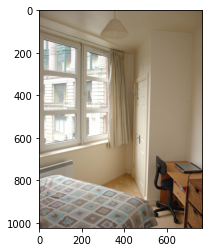

In [2043]:
image = mpimg.imread(path_to_image)
plt.imshow(image)
plt.show()

<h3>III) Show Image Segmentation from ADE20k

In [2044]:
for filename in glob.glob(path_to_image_seg):
    path_to_image_seg = filename

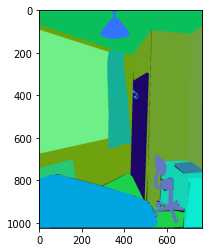

In [2045]:
image_seg = mpimg.imread(path_to_image_seg)
plt.imshow(image_seg)
plt.show()

In [2046]:
image_num = (image_seg[900][200]*255).astype(int)

<h3>IV) Convert to Object Labels</h3>

From https://github.com/CSAILVision/ADE20K/blob/main/utils/utils_ade20k.py

In [2047]:
from PIL import Image
with Image.open(path_to_image_seg) as io:
        seg = np.array(io);

In [2048]:
R = seg[:,:,0];
G = seg[:,:,1];
B = seg[:,:,2];
ObjectClassMasks = (R/10).astype(np.int32)*256+(G.astype(np.int32));

In [2049]:
ObjectClassMasks

array([[  0,   0, 447, ..., 447,   0,   0],
       [  0,   0, 447, ..., 447,   0,   0],
       [  0,   0, 447, ..., 447,   0,   0],
       ...,
       [  0,   0, 165, ..., 491, 491,   0],
       [  0,   0, 165, ..., 491, 491,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [2050]:
image_shape=ObjectClassMasks.shape

Matches shape of image.

In [2051]:
image_height = image_shape[0]
image_width = image_shape[1]

In [2052]:
object_id = ObjectClassMasks[900][200]

By visual inspection, (900,200) should be classified as 'bed'

<h3>V) Object Name Lookup by Label</h3>

I got the `index_ade20k.pkl` from the .zip in the same manner as the validation images.

In [2053]:
with open('/Volumes/gordonssd/ADE20K_2021_17_01/index_ade20k.pkl', 'rb') as f:
    index_ade20k = pkl.load(f)

In [2054]:
index_ade20k['objectnames']

['-',
 'aarm panel',
 'abacus',
 'accordion, piano accordion, squeeze box',
 'acropolis',
 'ad, advertisement, advertizement, advertising, advertizing, advert',
 'adding machine',
 'advertisement board',
 'aerial',
 'air conditioner, air conditioning',
 'air hockey table',
 'air machine',
 'aircraft carrier',
 'airplane, aeroplane, plane',
 'airport cart',
 'alarm',
 'alarm clock',
 'alembic',
 'alga',
 'algae',
 "altar, communion table, Lord's table",
 'altarpiece',
 'amphitheater',
 'amphora',
 'anchor',
 'andiron',
 'andirons',
 'animal toy',
 'animal, animate being, beast, brute, creature, fauna',
 'animals',
 'antenna',
 'antenna, aerial, transmitting aerial',
 'antler',
 'antlers',
 'anvil',
 'aperture',
 'apparatus',
 'apparel, wearing apparel, dress, clothes',
 'apple',
 'apples',
 'appliance',
 'apron',
 'aquarium',
 'aqueduct',
 'arbor',
 'arcade',
 'arcade machine',
 'arcade machines',
 'arcade, colonnade',
 'arcades',
 'arch',
 'arch, archway',
 'arches',
 'arm',
 'arm pane

In [2055]:
obj_name = index_ade20k['objectnames'][object_id]

In [2056]:
obj_name

'bed column'

Not sure why the object ids are 1 ahead. Manually minus for now.

In [2057]:
index_ade20k['objectnames'][object_id - 1]

'bed'

<h1>Step 1: Word-trace alignments and segmentation mask</h1>

<h3>I) Get traces</h3>

In [2058]:
loc_narr.traces

[[{'x': 0.6408, 'y': 0.1371, 't': 0.013},
  {'x': 0.6408, 'y': 0.2455, 't': 0.029},
  {'x': 0.6354, 'y': 0.3292, 't': 0.045},
  {'x': 0.6152, 'y': 0.4101, 't': 0.062},
  {'x': 0.6098, 'y': 0.4897, 't': 0.079},
  {'x': 0.6098, 'y': 0.524, 't': 0.097},
  {'x': 0.6098, 'y': 0.5542, 't': 0.114},
  {'x': 0.6079, 'y': 0.5775, 't': 0.13},
  {'x': 0.5969, 'y': 0.5912, 't': 0.147},
  {'x': 0.5878, 'y': 0.6008, 't': 0.164},
  {'x': 0.586, 'y': 0.6022, 't': 0.18},
  {'x': 0.5841, 'y': 0.6036, 't': 0.214},
  {'x': 0.5805, 'y': 0.6049, 't': 0.23},
  {'x': 0.575, 'y': 0.6077, 't': 0.247},
  {'x': 0.5476, 'y': 0.6159, 't': 0.264},
  {'x': 0.4378, 'y': 0.6324, 't': 0.28},
  {'x': 0.339, 'y': 0.6434, 't': 0.297},
  {'x': 0.2183, 'y': 0.6461, 't': 0.314},
  {'x': 0.136, 'y': 0.6461, 't': 0.33},
  {'x': 0.0939, 'y': 0.6516, 't': 0.348},
  {'x': 0.0647, 'y': 0.6543, 't': 0.364},
  {'x': 0.0445, 'y': 0.6598, 't': 0.381},
  {'x': 0.0354, 'y': 0.6694, 't': 0.397},
  {'x': 0.0354, 'y': 0.6859, 't': 0.414},
  

In [2059]:
trace_seg = loc_narr.traces[0]

In [2060]:
points = [(seg['x'], seg['y']) for seg in trace_seg]

In [2061]:
points

[(0.6408, 0.1371),
 (0.6408, 0.2455),
 (0.6354, 0.3292),
 (0.6152, 0.4101),
 (0.6098, 0.4897),
 (0.6098, 0.524),
 (0.6098, 0.5542),
 (0.6079, 0.5775),
 (0.5969, 0.5912),
 (0.5878, 0.6008),
 (0.586, 0.6022),
 (0.5841, 0.6036),
 (0.5805, 0.6049),
 (0.575, 0.6077),
 (0.5476, 0.6159),
 (0.4378, 0.6324),
 (0.339, 0.6434),
 (0.2183, 0.6461),
 (0.136, 0.6461),
 (0.0939, 0.6516),
 (0.0647, 0.6543),
 (0.0445, 0.6598),
 (0.0354, 0.6694),
 (0.0354, 0.6859),
 (0.0482, 0.7119),
 (0.0592, 0.7394),
 (0.0647, 0.7668),
 (0.072, 0.8066),
 (0.0903, 0.8244),
 (0.1378, 0.8327),
 (0.1982, 0.8327),
 (0.2768, 0.8286),
 (0.3427, 0.8162),
 (0.3866, 0.8025),
 (0.4085, 0.7915),
 (0.4177, 0.7778),
 (0.4195, 0.7641),
 (0.4195, 0.7517),
 (0.4049, 0.7435),
 (0.3482, 0.738),
 (0.2732, 0.738),
 (0.2019, 0.76),
 (0.1433, 0.7833),
 (0.1031, 0.8148),
 (0.0793, 0.8519),
 (0.072, 0.9067),
 (0.0866, 0.9534),
 (0.1177, 0.9849),
 (0.1799, 1.0042),
 (0.2531, 1.011),
 (0.3463, 1.0055),
 (0.3957, 0.9904),
 (0.436, 0.9657),
 (0.46

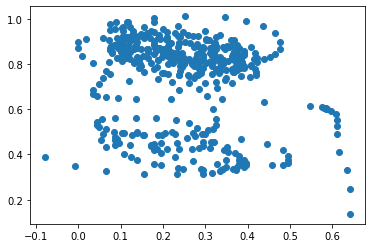

In [2062]:
x = [seg['x'] for seg in trace_seg]
y = [seg['y'] for seg in trace_seg]

plt.scatter(x, y)
plt.show()

Clearly the trace segments are not meaningfully aligned to words/phrases out of the box.

<h3>II) Align traces to word/phrase</h3>

In [2063]:
loc_narr.caption

'In this image on the left side I can see a bed and a window. On right side, I can see some object on the table and a door. At the top I can see the light.'

In [2064]:
timed_caption = loc_narr.timed_caption
timed_caption

[{'utterance': 'In', 'start_time': 0.0, 'end_time': 0.0},
 {'utterance': 'this', 'start_time': 0.0, 'end_time': 0.8},
 {'utterance': 'image', 'start_time': 0.8, 'end_time': 1.0},
 {'utterance': 'on', 'start_time': 1.0, 'end_time': 1.4},
 {'utterance': 'the', 'start_time': 1.4, 'end_time': 1.6},
 {'utterance': 'left', 'start_time': 1.6, 'end_time': 2.1},
 {'utterance': 'side', 'start_time': 2.1, 'end_time': 2.3},
 {'utterance': 'I', 'start_time': 2.3, 'end_time': 2.6},
 {'utterance': 'can', 'start_time': 2.6, 'end_time': 3.0},
 {'utterance': 'see', 'start_time': 3.0, 'end_time': 3.3},
 {'utterance': 'a', 'start_time': 3.3, 'end_time': 4.4},
 {'utterance': 'bed', 'start_time': 4.4, 'end_time': 5.2},
 {'utterance': 'and', 'start_time': 5.2, 'end_time': 7.5},
 {'utterance': 'a', 'start_time': 7.5, 'end_time': 7.5},
 {'utterance': 'window.', 'start_time': 7.5, 'end_time': 8.1},
 {'utterance': 'On', 'start_time': 8.1, 'end_time': 11.5},
 {'utterance': 'right', 'start_time': 11.6, 'end_time':

In [2065]:
traces

[[{'x': 0.6408, 'y': 0.1371, 't': 0.013},
  {'x': 0.6408, 'y': 0.2455, 't': 0.029},
  {'x': 0.6354, 'y': 0.3292, 't': 0.045},
  {'x': 0.6152, 'y': 0.4101, 't': 0.062},
  {'x': 0.6098, 'y': 0.4897, 't': 0.079},
  {'x': 0.6098, 'y': 0.524, 't': 0.097},
  {'x': 0.6098, 'y': 0.5542, 't': 0.114},
  {'x': 0.6079, 'y': 0.5775, 't': 0.13},
  {'x': 0.5969, 'y': 0.5912, 't': 0.147},
  {'x': 0.5878, 'y': 0.6008, 't': 0.164},
  {'x': 0.586, 'y': 0.6022, 't': 0.18},
  {'x': 0.5841, 'y': 0.6036, 't': 0.214},
  {'x': 0.5805, 'y': 0.6049, 't': 0.23},
  {'x': 0.575, 'y': 0.6077, 't': 0.247},
  {'x': 0.5476, 'y': 0.6159, 't': 0.264},
  {'x': 0.4378, 'y': 0.6324, 't': 0.28},
  {'x': 0.339, 'y': 0.6434, 't': 0.297},
  {'x': 0.2183, 'y': 0.6461, 't': 0.314},
  {'x': 0.136, 'y': 0.6461, 't': 0.33},
  {'x': 0.0939, 'y': 0.6516, 't': 0.348},
  {'x': 0.0647, 'y': 0.6543, 't': 0.364},
  {'x': 0.0445, 'y': 0.6598, 't': 0.381},
  {'x': 0.0354, 'y': 0.6694, 't': 0.397},
  {'x': 0.0354, 'y': 0.6859, 't': 0.414},
  

Authors did not share specifications as to how they did the word-trace alignment. I am thinking for words that have the same start_time and end_time they will make a phrase with the next word. Otherwise, they will be aligned on their own with a trace.

For the phrases/words, I will use start_time and end_time window to get the according trace coordinates. For the sake of convenience, I will just use one trace segment. Also I will assume there won't be 2 consecutives words that have start_time==end_time which is actually reasonable because it is probably impossible to utter 2 words in less than 0.1s

<b>step i: Get {phrase/word: (start_time, end_time)}</b>

In [2066]:
word_trace_align = {}

In [2067]:
save_word = ''
for word in timed_caption:
    key = save_word + word['utterance']
    save_word = ''
    # Check if start_time match end_time
    if (word['start_time']==word['end_time']):
        # Make phrase with next word
        save_word = word['utterance'] + ' '
        continue
    word_trace_align[key]=(word['start_time'], word['end_time'])

In [2068]:
word_trace_align

{'In this': (0.0, 0.8),
 'image': (0.8, 1.0),
 'on': (16.9, 17.1),
 'the': (21.7, 21.9),
 'left': (1.6, 2.1),
 'side': (2.1, 2.3),
 'I': (20.9, 21.2),
 'can': (21.2, 21.5),
 'see': (21.5, 21.7),
 'a': (19.6, 19.7),
 'bed': (4.4, 5.2),
 'and': (17.3, 19.6),
 'a window.': (7.5, 8.1),
 'On': (8.1, 11.5),
 'right': (11.6, 12.3),
 'side,': (12.3, 12.4),
 'some': (13.2, 16.4),
 'object': (16.4, 16.9),
 'the table': (17.1, 17.3),
 'door.': (19.7, 19.9),
 'At': (19.9, 20.6),
 'top': (20.8, 20.9),
 'light.': (21.9, 22.2)}

I just realised this will have an issue with repeated words.

<i>Alternate representation</i>

In [2069]:
word_trace_align = []

In [2070]:
save_word = ''
for word in timed_caption:
    key = save_word + word['utterance']
    save_word = ''
    # Check if start_time match end_time
    if (word['start_time']==word['end_time']):
        # Make phrase with next word
        save_word = word['utterance'] + ' '
        continue
    word_trace_align.append({key: (word['start_time'], word['end_time'])})

In [2071]:
word_trace_align

[{'In this': (0.0, 0.8)},
 {'image': (0.8, 1.0)},
 {'on': (1.0, 1.4)},
 {'the': (1.4, 1.6)},
 {'left': (1.6, 2.1)},
 {'side': (2.1, 2.3)},
 {'I': (2.3, 2.6)},
 {'can': (2.6, 3.0)},
 {'see': (3.0, 3.3)},
 {'a': (3.3, 4.4)},
 {'bed': (4.4, 5.2)},
 {'and': (5.2, 7.5)},
 {'a window.': (7.5, 8.1)},
 {'On': (8.1, 11.5)},
 {'right': (11.6, 12.3)},
 {'side,': (12.3, 12.4)},
 {'I': (12.4, 12.7)},
 {'can': (12.7, 13.1)},
 {'see': (13.1, 13.2)},
 {'some': (13.2, 16.4)},
 {'object': (16.4, 16.9)},
 {'on': (16.9, 17.1)},
 {'the table': (17.1, 17.3)},
 {'and': (17.3, 19.6)},
 {'a': (19.6, 19.7)},
 {'door.': (19.7, 19.9)},
 {'At': (19.9, 20.6)},
 {'the': (20.6, 20.8)},
 {'top': (20.8, 20.9)},
 {'I': (20.9, 21.2)},
 {'can': (21.2, 21.5)},
 {'see': (21.5, 21.7)},
 {'the': (21.7, 21.9)},
 {'light.': (21.9, 22.2)}]

<b>step ii: Convert (start_time, end_time) to trace coordinates that fall within the time window</b>

In [2072]:
for w in word_trace_align:
    # Get key... I admit this is not very elegant
    key = next(iter(w))
    start_time = w[key][0]
    end_time = w[key][1]
    # Filter trace_seg for items with t value within start_time:end_time
    w[key]=list(filter(lambda coord: start_time<=coord['t']<= end_time, trace_seg))
    

In [2073]:
word_trace_align

[{'In this': [{'x': 0.6408, 'y': 0.1371, 't': 0.013},
   {'x': 0.6408, 'y': 0.2455, 't': 0.029},
   {'x': 0.6354, 'y': 0.3292, 't': 0.045},
   {'x': 0.6152, 'y': 0.4101, 't': 0.062},
   {'x': 0.6098, 'y': 0.4897, 't': 0.079},
   {'x': 0.6098, 'y': 0.524, 't': 0.097},
   {'x': 0.6098, 'y': 0.5542, 't': 0.114},
   {'x': 0.6079, 'y': 0.5775, 't': 0.13},
   {'x': 0.5969, 'y': 0.5912, 't': 0.147},
   {'x': 0.5878, 'y': 0.6008, 't': 0.164},
   {'x': 0.586, 'y': 0.6022, 't': 0.18},
   {'x': 0.5841, 'y': 0.6036, 't': 0.214},
   {'x': 0.5805, 'y': 0.6049, 't': 0.23},
   {'x': 0.575, 'y': 0.6077, 't': 0.247},
   {'x': 0.5476, 'y': 0.6159, 't': 0.264},
   {'x': 0.4378, 'y': 0.6324, 't': 0.28},
   {'x': 0.339, 'y': 0.6434, 't': 0.297},
   {'x': 0.2183, 'y': 0.6461, 't': 0.314},
   {'x': 0.136, 'y': 0.6461, 't': 0.33},
   {'x': 0.0939, 'y': 0.6516, 't': 0.348},
   {'x': 0.0647, 'y': 0.6543, 't': 0.364},
   {'x': 0.0445, 'y': 0.6598, 't': 0.381},
   {'x': 0.0354, 'y': 0.6694, 't': 0.397},
   {'x': 0

Seems like words after 'On' align to traces in the second segment so I will drop those for now.

In [2074]:
word_trace_align = word_trace_align[:13]

<h3>III) Get convex hull of traces</h3>

Managed to install scipy on M1 Mac using `brew install openblas
OPENBLAS="$(brew --prefix openblas)" pip install numpy scipy
` https://stackoverflow.com/a/67586301

In [2075]:
points = word_trace_align[0]['In this']
points = np.array([[point['x']*image_width, point['y']*image_height] for point in points])
print(points.shape)
print(points)

(47, 2)
[[492.1344 140.3904]
 [492.1344 251.392 ]
 [487.9872 337.1008]
 ...
 [ 60.9024 872.3456]
 [ 55.296  928.4608]
 [ 66.5088 976.2816]]


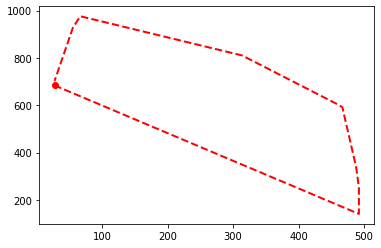

In [2076]:
points = word_trace_align[0]['In this']
points = np.array([[point['x']*image_width, point['y']*image_height] for point in points])
hull = ConvexHull(points)
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

In [2077]:
for w in word_trace_align:
    # Get key... I admit this is not very elegant
    key = next(iter(w))
    points = w[key]
    points = np.array([[point['x'], point['y']] for point in points])
    hull = ConvexHull(points)
    w[key] = hull

In [2078]:
word_trace_align

[{'In this': <scipy.spatial.qhull.ConvexHull at 0x14787ff70>},
 {'image': <scipy.spatial.qhull.ConvexHull at 0x14787f760>},
 {'on': <scipy.spatial.qhull.ConvexHull at 0x147a3e550>},
 {'the': <scipy.spatial.qhull.ConvexHull at 0x154ab8bb0>},
 {'left': <scipy.spatial.qhull.ConvexHull at 0x14797bd90>},
 {'side': <scipy.spatial.qhull.ConvexHull at 0x124731f40>},
 {'I': <scipy.spatial.qhull.ConvexHull at 0x154ab81c0>},
 {'can': <scipy.spatial.qhull.ConvexHull at 0x154ab8af0>},
 {'see': <scipy.spatial.qhull.ConvexHull at 0x14787f8b0>},
 {'a': <scipy.spatial.qhull.ConvexHull at 0x14787fa30>},
 {'bed': <scipy.spatial.qhull.ConvexHull at 0x14787f5b0>},
 {'and': <scipy.spatial.qhull.ConvexHull at 0x14787f6a0>},
 {'a window.': <scipy.spatial.qhull.ConvexHull at 0x14787fcd0>}]

<h3>IV) Get counts of unique labels within hull</h3>

Used this to get labels within hull https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python

https://www.kite.com/python/answers/how-to-count-frequency-of-unique-values-in-a-numpy-array-in-python

I don't want to count zeros so I will remove them.
https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html

<h3>V) Get most frequent label within hull</h3>

Create function for IV and V

In [2079]:
def hull_to_name(hull):
    points = hull.points
    points = np.array([[point[0]*image_width, point[1]*image_height] for point in points])
    tupVerts = [(points[vtx,0], points[vtx,1]) for vtx in hull.vertices]
    p = Path(tupVerts) # make a polygon
    x, y = np.meshgrid(np.arange(image_width), np.arange(image_length)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 
    grid = p.contains_points(points)
    mask = grid.reshape(image_length,image_width) # now you have a mask with points inside a polygon
    labels_within_hull = mask*ObjectClassMasks
    labels = labels_within_hull[np.nonzero(labels_within_hull)]
    values, counts = np.unique(labels, return_counts=True)
    ind = np.argmax(counts)
    label = values[ind]
    return index_ade20k['objectnames'][label - 1]

Run it for all the hulls

In [2080]:
for w in word_trace_align:
    # Get key... I admit this is not very elegant
    key = next(iter(w))
    hull = w[key]
    w[key] = hull_to_name(hull)

In [2081]:
word_trace_align

[{'In this': 'wall'},
 {'image': 'bed'},
 {'on': 'bed'},
 {'the': 'bed'},
 {'left': 'bed'},
 {'side': 'bed'},
 {'I': 'bed'},
 {'can': 'bed'},
 {'see': 'bed'},
 {'a': 'bed'},
 {'bed': 'bed'},
 {'and': 'windowpane, window'},
 {'a window.': 'windowpane, window'}]

<h3>VI) TA DA!</h3>

https://stackoverflow.com/questions/287871/how-to-print-colored-text-to-the-terminal

In [2082]:
# for printing with colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [2083]:
for w in word_trace_align:
    # Get key... I admit this is not very elegant
    key = next(iter(w))
    name = w[key]
    print(key+'/'+bcolors.OKGREEN + name + bcolors.ENDC, end =" ")

In this/wall image/bed on/bed the/bed left/bed side/bed I/bed can/bed see/bed a/bed bed/bed and/windowpane, window a window./windowpane, window 

<h1>Step 2: Compute term frequency-inverse document frequency (tf-idf)</h1>